<a href="https://colab.research.google.com/github/ChristophWuersch/AppliedNeuralNetworks/blob/main/U02/FraudDetection_imbalanced_classes_SOLUTION-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="Bilder/ost_logo.png" width="240" height="120" align="right"/>
<div style="text-align: left"> <b> Applied Neural Networks | FS 2022 </b><br>
<a href="mailto:christoph.wuersch@ost.ch"> © Christoph Würsch </a> </div>
<a href="https://www.ost.ch/de/forschung-und-dienstleistungen/technik/systemtechnik/ice-institut-fuer-computational-engineering/"> Eastern Switzerland University of Applied Sciences OST | ICE </a>


# Imbalanced classification: Missbräuchliche Kreditkartenbezüge

Demonstration des Umgangs mit stark unausgewogenen Klassifikationsproblemen.

## Introduction

Dieses Beispiel befasst sich mit der
[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/)
Datensatz, um zu demonstrieren, wie
wie man ein Klassifizierungsmodell auf Daten mit stark unausgewogenen Klassen trainiert.

## Datenaufbereitung

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [44]:
import csv
import numpy as np
import pandas as pd

# Get the real data from https://www.kaggle.com/mlg-ulb/creditcardfraud/
#fname = "creditcard.csv"

fname='/content/gdrive/MyDrive/ANN_Data/creditcard.csv'


all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)


HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


## (a) Aufteilen in einen Trainings- und Validierungsdatensatz

In [2]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))


Number of training samples: 227846
Number of validation samples: 56961


## (b) Analyse des Klassenungleichgewichts in der Response

In [45]:
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)Bes

Number of positive samples in training data: 417 (0.18% of total)


## (c) Standardisierung der Daten auf Basis der Statistik der Trainingsdaten

In [4]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std


## (d) Aufbauen eines binären Klassifizierungsmodells

In [35]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               7936      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 106,753
Trainable params: 106,753
Non-trainable params: 0
________________________________________________

## (e) Trainieren Sie das Modell mit dem `class_weight`-Argument 

In [42]:
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
print(weight_for_0, weight_for_1)

4.396976638863118e-06 0.002398081534772182


In [43]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

#callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

history=model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)


Epoch 1/30
112/112 - 1s - loss: 8.0701e-07 - fn: 6.0000 - fp: 3389.0000 - tn: 224040.0000 - tp: 411.0000 - precision: 0.1082 - recall: 0.9856 - val_loss: 0.0302 - val_fn: 10.0000 - val_fp: 315.0000 - val_tn: 56571.0000 - val_tp: 65.0000 - val_precision: 0.1711 - val_recall: 0.8667
Epoch 2/30
112/112 - 1s - loss: 2.6880e-07 - fn: 0.0000e+00 - fp: 2383.0000 - tn: 225046.0000 - tp: 417.0000 - precision: 0.1489 - recall: 1.0000 - val_loss: 0.0220 - val_fn: 10.0000 - val_fp: 351.0000 - val_tn: 56535.0000 - val_tp: 65.0000 - val_precision: 0.1562 - val_recall: 0.8667
Epoch 3/30
112/112 - 1s - loss: 2.7689e-07 - fn: 4.0000 - fp: 2619.0000 - tn: 224810.0000 - tp: 413.0000 - precision: 0.1362 - recall: 0.9904 - val_loss: 0.0221 - val_fn: 9.0000 - val_fp: 372.0000 - val_tn: 56514.0000 - val_tp: 66.0000 - val_precision: 0.1507 - val_recall: 0.8800
Epoch 4/30
112/112 - 1s - loss: 2.7579e-07 - fn: 3.0000 - fp: 2922.0000 - tn: 224507.0000 - tp: 414.0000 - precision: 0.1241 - recall: 0.9928 - val_los

Epoch 30/30
112/112 - 1s - loss: 2.9105e-07 - fn: 2.0000 - fp: 2141.0000 - tn: 225288.0000 - tp: 415.0000 - precision: 0.1624 - recall: 0.9952 - val_loss: 0.0180 - val_fn: 11.0000 - val_fp: 167.0000 - val_tn: 56719.0000 - val_tp: 64.0000 - val_precision: 0.2771 - val_recall: 0.8533


In [24]:
history.history.keys()

dict_keys(['loss', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])

## (f) Lernkurven

Plotten Sie die Lernkurven für folgende Metriken:

- `keras.metrics.FalseNegatives(name="fn")`
- `keras.metrics.FalsePositives(name="fp")`
- `keras.metrics.TrueNegatives(name="tn")`
- `keras.metrics.TruePositives(name="tp")`
- `keras.metrics.Precision(name="precision")`
- `keras.metrics.Recall(name="recall")`



In [25]:
import matplotlib.pyplot as plt

def plot_history(history, keyList):
    plt.figure()

    for key in keyList:
        val_key='val_'+key
        plt.plot(history.history[key])
        plt.plot(history.history[val_key])
        plt.title(key)
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend([key, val_key], loc='upper left')
        plt.grid(True); plt.show()
    

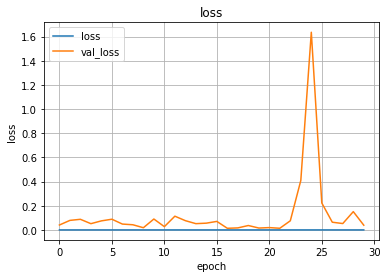

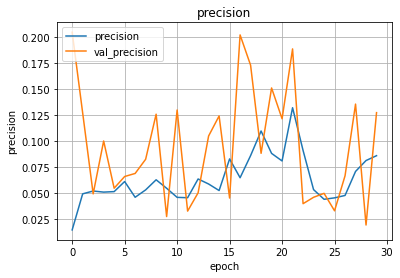

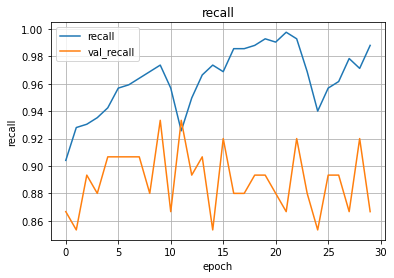

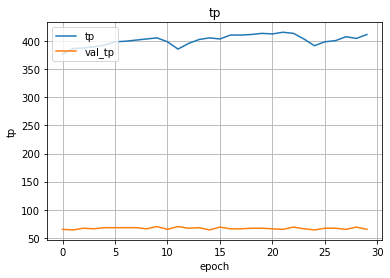

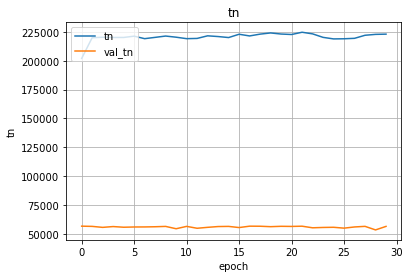

In [37]:
plot_history(history,['loss','precision','recall','tp','tn'])

## (g) Interpretation, Bewertung des Learners

In [38]:
history.history['val_tp'][-1]

65.0

In [39]:
history.history['val_fp'][-1]

446.0

In [40]:
history.history['val_fn'][-1]

10.0

Am Ende des Trainings haben wir von 56.961 Validierungstransaktionen:

- 66 von ihnen korrekt als betrügerisch identifiziert
- 9 betrügerische Transaktionen werden übersehen
- um den Preis, dass wir 441 legitime Transaktionen falsch kennzeichnen

In der realen Welt würde man der Klasse 1 ein noch höheres Gewicht beimessen,
um der Tatsache Rechnung zu tragen, dass falsche Negativmeldungen teurer sind als falsche Positivmeldungen.

Das nächste Mal, wenn Ihre Kreditkarte bei einem Online-Einkauf abgelehnt wird - das ist der Grund.

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]

model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)